# Step 1: Initial Preprocessing

In [ ]:
!ln -s "/content/drive/MyDrive/gait" "/content/gait"
!ln -s "/content/drive/MyDrive/ConvertedGaitData" "/content/converted"

In [ ]:
!ln -s "/content/drive/MyDrive/gait" "/content/gait"

In [ ]:
!ln -s "/content/drive/MyDrive/Deep_PreProcessed" "/content/Deep"

In [ ]:
import subprocess

def check_video_corruption(file_path):
    try:
        # Use ffmpeg to check the video file
        result = subprocess.run(['ffmpeg', '-v', 'error', '-i', file_path, '-f', 'null', '-'], stderr=subprocess.PIPE)
        if result.returncode != 0:
            print(f"The video file {file_path} is corrupt.")
            return False
        else:
            print(f"The video file {file_path} is not corrupt.")
            return True
    except Exception as e:
        print(f"An error occurred: {e}")

def convert_mov_to_h264(input_file, output_file):
    try:
        # Convert the MOV file to H.264 using ffmpeg
        subprocess.run(['ffmpeg', '-i', input_file, '-c:v', 'libx264', '-an', output_file])
        print(f"Conversion complete. The file has been saved as {output_file}.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
import os
import re
from tqdm.notebook import tqdm
# Define the paths and match string
path = "/content/gait"
output_dir = "/content/converted/front"
match_string = ".*front\\.mov$"

# Iterate through each person in the directory
for person in tqdm(os.listdir(path)):
    person_path = os.path.join(path, person)

    # Ensure we're only looking at directories
    if os.path.isdir(person_path):
        for file_ in os.listdir(person_path):
            # Check if the file matches the specified pattern
            if re.match(match_string, file_, re.IGNORECASE):
                input_file_path = os.path.join(person_path, file_)

                # Create the output directory for this person if it doesn't exist
                person_output_file = os.path.join(output_dir, person + ".mp4")

                # Call the get_human_silhouettes function
                if(check_video_corruption(input_file_path)):
                  convert_mov_to_h264(input_file_path, person_output_file)


  0%|          | 0/47 [00:00<?, ?it/s]

The video file /content/gait/sub42/adelka_m_1_front.MOV is corrupt.
The video file /content/gait/sub29/ahmedma_m_1_front.MOV is corrupt.
The video file /content/gait/sub43/yassercollect_m_1_front.MOV is not corrupt.
Conversion complete. The file has been saved as /content/converted/front/sub43.mp4.
The video file /content/gait/sub17/sharsharj_m_1_front.MOV is not corrupt.
Conversion complete. The file has been saved as /content/converted/front/sub17.mp4.
The video file /content/gait/sub32/mohamedsla_m_1_front.MOV is corrupt.
The video file /content/gait/sub12/ahmedt_m_1_front.MOV is not corrupt.
Conversion complete. The file has been saved as /content/converted/front/sub12.mp4.
The video file /content/gait/sub40/youssefham_m_1_front.MOV is corrupt.
The video file /content/gait/sub36/menatullah_f_1_front.MOV is not corrupt.
Conversion complete. The file has been saved as /content/converted/front/sub36.mp4.
The video file /content/gait/sub11/ahmedh_m_1_front.MOV is not corrupt.
Conversio

# Step 2: Stablization and Silhoutte extraction

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!rm -r /content/Output

In [ ]:
import torch
import cv2
import numpy as np
import torchvision.models.segmentation as segmentation_models
import torchvision
def mask_persons_only(frames, model):
    # Convert the frame to a tensor and normalize it
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    processed_images = []
    for frame in frames:
      input_tensor = preprocess(frame)
      processed_images.append(input_tensor)
    batch_tensor = torch.stack(processed_images)
    batch_tensor = batch_tensor.to(device)
      # Add batch dimension

    # Perform the forward pass to get the output
    with torch.no_grad():
        output = model(batch_tensor)['out']  # The output is a tensor with shape [21, H, W]

    # Get the segmentation map for the "person" class (class 15)
    person_class = 15
    person_masks = output.argmax(1) == person_class
    masked_frames = []
    for i in range(len(person_masks)):
              # Apply the mask to the frame to get the silhouette
              # Convert the mask to uint8
              person_mask = person_masks[i].byte().cpu().numpy()
              person_mask = cv2.resize(person_mask, (frames[i].shape[1], frames[i].shape[0]))
              person_mask = (person_mask * 255).astype(np.uint8)
              masked_frames.append(person_mask)


    return masked_frames

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import torch
import torchvision.models.segmentation as segmentation_models
import imutils
model = segmentation_models.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21, aux_params=None)
model = model.to(device)
model.eval()
def get_human_silhouettes(video_path, output_dir, batch_size=10, padding=5, threshold=15):
    # Create output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    batch_frames = []
    last_saved_frame = None
    silhouette_list = []
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # Define the codec
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_path = os.path.join(person_output_dir, f'stablized.mp4')
    video_path_sil = os.path.join(person_output_dir, f'sil.mp4')
    out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))
    out_sil = cv2.VideoWriter(video_path, fourcc, fps, (width, height), isColor=False)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB and preprocess
        frame = frame[0: -100, :]
        frame = imutils.resize(frame, width=500)
        batch_frames.append(frame)
        frame_count += 1

        if len(batch_frames) == batch_size or not ret:
            # Perform segmentation on the batch
            predicted_masks = mask_persons_only(batch_frames, model)
            for i in range(len(batch_frames)):
                contours, _ = cv2.findContours(silhouette, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours) == 0:
                    continue  # No contours found

                # Find the largest contour
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                side = max(w, h)
                sidePadding = (side - w) // 2
                topPadding = (side - h) // 2
                cropped = batch_frames[i][y - padding:y + h + padding, x - padding:x + w + padding]
                if cropped is None:
                  continue
                # Get contour
                try:
                  gr = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
                except:
                  continue
                _, thresh1 = cv2.threshold(gr, 150, 255, cv2.THRESH_BINARY_INV)
                mergeThresh = cv2.bitwise_and(thresh1, croppedSillh)
                paddedFrame = cv2.copyMakeBorder(mergeThresh, topPadding, topPadding, sidePadding, sidePadding, cv2.BORDER_CONSTANT)

                # Resize to ensure same dimensions
                if last_saved_frame is not None:
                    paddedFrame = cv2.resize(paddedFrame, last_saved_frame.shape[::-1])

                # Save the silhouette frame to the output directory
                if last_saved_frame is None or np.mean(np.abs(paddedFrame.astype(np.float32) - last_saved_frame.astype(np.float32))) >= threshold:
                    out.write(cropped)
                    out_sil.write(cropped)
                    last_saved_frame = paddedFrame
                    silhouette_list.append(paddedFrame)

            # Clear the batch lists
            batch_frames = []
            print(f"Processed {frame_count} frames, saved {len(silhouette_list)} frames")

    print(f"Total silhouettes saved: {len(silhouette_list)}")
    cap.release()
    else:
        print("No silhouettes to save")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import os
import re

# Define the paths and match string
path = "/content/gait"
output_dir = '/content/gait/Output'
match_string = ".*front\\.mov$"

# Iterate through each person in the directory
for person in os.listdir(path):
    person_path = os.path.join(path, person)

    # Ensure we're only looking at directories
    if os.path.isdir(person_path):
        for file_ in os.listdir(person_path):
            # Check if the file matches the specified pattern
            if re.match(match_string, file_, re.IGNORECASE):
                input_file_path = os.path.join(person_path, file_)

                # Create the output directory for this person if it doesn't exist
                person_output_dir = os.path.join(output_dir, person)
                if not os.path.exists(person_output_dir):
                    os.makedirs(person_output_dir)

                # Call the get_human_silhouettes function
                get_human_silhouettes(input_file_path, person_output_dir)
                print(f"Processed {input_file_path} and saved results to {person_output_dir}")


Total silhouettes saved: 0
No silhouettes to save
Processed /content/gait/sub42/adelka_m_1_front.MOV and saved results to /content/gait/Output/sub42
Total silhouettes saved: 0
No silhouettes to save
Processed /content/gait/sub29/ahmedma_m_1_front.MOV and saved results to /content/gait/Output/sub29
Processed 10 frames, saved 1 frames
Processed 20 frames, saved 1 frames
Processed 30 frames, saved 3 frames
Processed 40 frames, saved 7 frames
Processed 50 frames, saved 11 frames
Processed 60 frames, saved 16 frames
Processed 70 frames, saved 16 frames
Processed 80 frames, saved 17 frames
Processed 90 frames, saved 19 frames
Processed 100 frames, saved 22 frames
Processed 110 frames, saved 25 frames
Processed 120 frames, saved 25 frames
Processed 130 frames, saved 25 frames
Processed 140 frames, saved 25 frames
Processed 150 frames, saved 25 frames
Processed 160 frames, saved 25 frames
Processed 170 frames, saved 25 frames
Processed 180 frames, saved 25 frames
Processed 190 frames, saved 25

# Step 3: Skeleton Extraction

In [ ]:
import os
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'

!echo $HOME_PATH

./


In [ ]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

!wget "https://drive.usercontent.google.com/download?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download&authuser=0&confirm=t&uuid=50355e54-0445-4875-9d0e-3866a1f6239d&at=APZUnTVA3sHsK5rk-u2O6phIms2L%3A1711987634035" -O models.zip

# !cp "/content/drive/MyDrive/VTO/openpose/models.zip" "/content/"
!unzip models.zip -d openpose

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

In [ ]:
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [ ]:
!cd openpose && rm -rf build || true && mkdir build

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [ ]:
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.2") 
-- Building with CUDA.
-- CUDA detected: 12.2
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

In [ ]:
!mkdir images

In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

In [ ]:
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video /content/front/Sub0.mp4 --write_json /content/test --display 0  --write_video /content/test/openpose.avi
!ffmpeg -y -loglevel info -i /content/test/openpose.avi /content/test/output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 16.512827 seconds.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbi

In [ ]:
!rm -rf /content/front/pose
!mkdir /content/front/pose

In [ ]:
import cv2
import os
import subprocess
from openpose.build.python.openpose import pyopenpose as op
import json
def get_human_silhouette_vids(input_file_path, person_output_dir):
    # Set up OpenPose
    params = dict()
    params["model_folder"] = "/content/openpose/models/"

    # Initialize OpenPose
    opWrapper = op.WrapperPython()
    opWrapper.configure(params)
    opWrapper.start()

    # Create directories if they don't exist
    if not os.path.exists(person_output_dir):
        os.makedirs(person_output_dir)

    write_json_path = os.path.join(person_output_dir, 'json')
    final_video_path = os.path.join(person_output_dir, 'subject_output.mp4')

    # Process video frame by frame
    cap = cv2.VideoCapture(input_file_path)
    if not cap.isOpened():
        print(f"Error opening video file {input_file_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(final_video_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        datum = op.Datum()
        datum.cvInputData = frame
        opWrapper.emplaceAndPop(op.VectorDatum([datum]))

        keypoints = datum.poseKeypoints

        # Save keypoints to JSON
        json_file_path = os.path.join(write_json_path, f"frame_{frame_count:06d}.json")
        os.makedirs(os.path.dirname(json_file_path), exist_ok=True)
        with open(json_file_path, 'w') as json_file:
            json.dump(keypoints.tolist(), json_file)

        out.write(datum.cvOutputData)
        frame_count += 1

    cap.release()
    out.release()
    print(f"Processed {input_file_path} and saved results to {person_output_dir}")


In [ ]:

# Example usage
input_file_path = "/content/front/Sub0.mp4"
person_output_dir = "/content/test"
get_human_silhouette_vids(input_file_path, person_output_dir)


Processed /content/front/Sub0.mp4 and saved results to /content/test


In [ ]:
!rm -rf /content/test
!mkdir /content/test

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re
# Define the paths and match string
input_dir = "/content/front"
output_dir = '/content/front/pose'
match_string = ".*\\.mp4$"
subject = 0

# Iterate through each file in the directory
for file_ in os.listdir(input_dir):
    # Check if the file matches the specified pattern
    if re.match(match_string, file_, re.IGNORECASE):
        input_file_path = os.path.join(input_dir, file_)
        person_name = os.path.splitext(file_)[0]

        # Create the output directory for this person if it doesn't exist
        person_output_dir = os.path.join(output_dir, person_name)
        if not os.path.exists(person_output_dir):
            os.makedirs(person_output_dir)

        # Call the get_human_silhouettes function
        get_human_silhouette_vids(input_file_path, person_output_dir)
        print(f"Processed {input_file_path} and saved results to {person_output_dir}")


Processed /content/front/Sub0.mp4 and saved results to /content/front/pose/Sub0
Processed /content/front/Sub0.mp4 and saved results to /content/front/pose/Sub0
Processed /content/front/Sub4.mp4 and saved results to /content/front/pose/Sub4
Processed /content/front/Sub4.mp4 and saved results to /content/front/pose/Sub4
Processed /content/front/Sub5.mp4 and saved results to /content/front/pose/Sub5
Processed /content/front/Sub5.mp4 and saved results to /content/front/pose/Sub5
Processed /content/front/Sub6.mp4 and saved results to /content/front/pose/Sub6
Processed /content/front/Sub6.mp4 and saved results to /content/front/pose/Sub6
Processed /content/front/Sub7.mp4 and saved results to /content/front/pose/Sub7
Processed /content/front/Sub7.mp4 and saved results to /content/front/pose/Sub7
Processed /content/front/Sub11.mp4 and saved results to /content/front/pose/Sub11
Processed /content/front/Sub11.mp4 and saved results to /content/front/pose/Sub11
Processed /content/front/Sub12.mp4 a

# Step 4: Experiments

In [ ]:
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/silhouette_vids /content/sil
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/pose /content/pose

In [ ]:
import os
import json
import numpy as np

# Initialize an empty list to store the pose data arrays
pose_data_dict = {}

# Define the path to the main directory
main_dir = '/content/pose'

# Traverse through all the subdirectories in the main directory
for sub_dir in os.listdir(main_dir):
    json_path = os.path.join(main_dir, sub_dir, 'json')

    # Check if the json_path exists and is a directory
    if os.path.isdir(json_path):
        pose_sub_list = []
        for json_file in os.listdir(json_path):
            file_path = os.path.join(json_path, json_file)

            # Read the JSON file and extract the pose data
            with open(file_path, 'r') as f:
                pose_data = json.load(f)

                # Convert the pose data to a NumPy array and append it to the list
                pose_data_array = np.array(pose_data)
                pose_sub_list.append(pose_data_array)
        pose_sub_array = np.concatenate(pose_sub_list,axis=0)
        pose_data_dict[sub_dir] = pose_sub_array

# Output the shape of the stacked array to verify
print(f'Stacked Pose Data Shape: {len(pose_data_dict)}')

Stacked Pose Data Shape: 25


In [ ]:
import os
import numpy as np
import cv2

def video_to_array(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Get video properties
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create an empty array to store frames
    video_array = np.zeros((num_frames, height, width), dtype=np.uint8)

    # Read and store frames
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Store frame in the array
        video_array[frame_idx, :, :] = gray_frame
        frame_idx += 1

    cap.release()

    return video_array

# Initialize an empty list to store the pose data arrays
vid_data_dict = {}

# Define the path to the main directory
main_dir = '/content/sil'

# Traverse through all the subdirectories in the main directory
for sub_dir in os.listdir(main_dir):
    vid_folder_path = os.path.join(main_dir, sub_dir)
    # Check if the json_path exists and is a directory
    if os.path.isdir(vid_folder_path):
      for file_name in os.listdir(vid_folder_path):
          video_path = os.path.join(vid_folder_path, file_name)
          video_array = video_to_array(video_path)
          if video_array is not None:
              vid_data_dict[sub_dir] = video_array
# Output the shape of the stacked array to verify
print(f'Stacked vid Data Shape: {len(vid_data_dict)}')

Stacked vid Data Shape: 25


In [ ]:
print(vid_data_dict["Sub0"].shape)
print(pose_data_dict["Sub0"].shape)

(230, 500, 500)
(230, 25, 3)


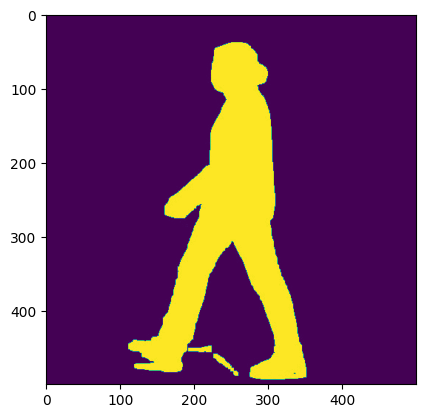

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(vid_data_dict["Sub0"][20])
plt.show()

filter data set

In [ ]:
filtered_vid_dict = {}
filtered_pose_dict = {}
minimum_num_frames = 230
labelCounter = 0
for key in vid_data_dict:
  if (vid_data_dict[key].shape[0]>=minimum_num_frames):
    filtered_vid_dict[labelCounter] = vid_data_dict[key]
    filtered_pose_dict[labelCounter] = pose_data_dict[key]
    labelCounter+=1

Distinct Samples

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize lists to store features (X) and labels (Y)
X_pose = []
X_GEI = []
Y = []

# Iterate over each class in the pose_data_list
for class_label in filtered_pose_dict:
    pose_array = filtered_pose_dict[class_label]
    vid_array = filtered_vid_dict[class_label]
    num_slices = pose_array.shape[0] // 23  # Total slices of size (23, 25, 3)

    for i in range(num_slices):
        # Extract a slice of size (23, 25, 3) from the first dimension
        start_slice = i*23
        slice_23 = pose_array[start_slice:start_slice+23, :, :]
        GEI = vid_array[start_slice:start_slice+23, :, :].mean(axis = 0,keepdims=True)
        # Append the slice to X and the label to Y
        X_pose.append(slice_23)
        X_GEI.append(GEI)
        Y.append(class_label)

# Convert X and Y lists to NumPy arrays for further processing
X_pose = np.array(X_pose)
X_GEI = np.array(X_GEI)
Y = np.array(Y)

indices = range(len(Y))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42,stratify=Y)
Y_train, Y_test = Y[train_indices], Y[test_indices]
X_train_pose = X_pose[train_indices]
X_train_GEI = X_GEI[train_indices]

X_test_pose = X_pose[test_indices]
X_test_GEI = X_GEI[test_indices]

# Output the shapes of the training and testing sets to verify
print(f'Training Pose Features Shape: {X_train_pose.shape}')
print(f'Training GEI Features Shape: {X_train_GEI.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Pose Features Shape: {X_test_pose.shape}')
print(f'Testing GEI Features Shape: {X_test_GEI.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Pose Features Shape: (361, 23, 25, 3)
Training GEI Features Shape: (361, 1, 500, 500)
Training Labels Shape: (361,)
Testing Pose Features Shape: (91, 23, 25, 3)
Testing GEI Features Shape: (91, 1, 500, 500)
Testing Labels Shape: (91,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le_ = LabelEncoder()
le_.fit(Y_train)
transformed_y = le_.transform(Y_train)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Assume you have X_train, y_train, X_test, y_test prepared as numpy arrays

# Example data preprocessing (if needed)
# Normalize the pixel values
X_train = X_train_GEI.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500,1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions (if needed)
predictions = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.0464 - loss: 4.4690 - val_accuracy: 0.0548 - val_loss: 3.0348
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.1210 - loss: 3.0015 - val_accuracy: 0.1370 - val_loss: 2.9532
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.1630 - loss: 2.8537 - val_accuracy: 0.3562 - val_loss: 2.5756
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.2912 - loss: 2.4100 - val_accuracy: 0.3973 - val_loss: 2.0049
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4340 - loss: 1.8704 - val_accuracy: 0.6986 - val_loss: 1.2366
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5847 - loss: 1.2613 - val_accuracy: 0.6849 - val_loss: 0.9804
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.6929 - loss: 0.9355 - val_accuracy: 0.8082 - val_loss: 0.6671
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.7507 - loss: 0.7496 - val_accuracy: 0.8767 - val_loss:

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_Pose = RandomForestClassifier(n_estimators = 100)
model_Pose.fit(X_train_pose.reshape(X_train_pose.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_GEI = RandomForestClassifier(n_estimators = 100)
model_GEI.fit(X_train_GEI.reshape(X_train_GEI.shape[0],-1), Y_train)

RandomForestClassifier()

Individual Performance

In [ ]:
y_pred = model_Pose.predict(X_test_pose.reshape(X_test_pose.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6
           2       1.00      0.25      0.40         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       0.57      0.80      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      0.50      0.67         4
          10       0.67      1.00      0.80         4
          11       1.00      1.00      1.00         4
          12       0.83      1.00      0.91         5
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         5
          15       0.80      1.00      0.89         4
          16       0.80      1.00      0.89         4
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred = model_GEI.predict(X_test_GEI.reshape(X_test_GEI.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.83      0.83      0.83         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      0.50      0.67         4
          12       0.83      1.00      0.91         5
          13       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         5
          15       0.75      0.75      0.75         4
          16       1.00      0.75      0.86         4
          17       1.00    

Ensemble

In [ ]:
weights = [1,1]
pred1 = model_Pose.predict_proba(X_test_pose.reshape(X_test_pose.shape[0],-1))
pred2 = model_GEI.predict_proba(X_test_GEI.reshape(X_test_GEI.shape[0],-1))
pred_avg = np.average(np.asarray([pred1,pred2]), axis=0, weights=weights)
y_pred = np.argmax(pred_avg, axis=1)
y_pred = le_.inverse_transform(y_pred)

In [ ]:
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      0.75      0.86         4
          16       1.00      1.00      1.00         4
          17       1.00    

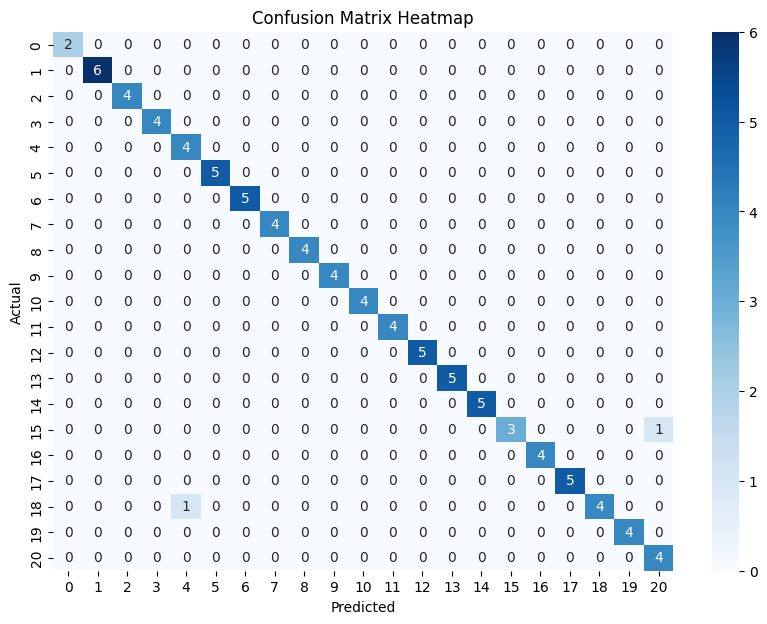

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()


Using Data Augmentation

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size = 0.2
stride = 5

# Initialize lists to store features (X) and labels (Y)
X_pose_train, X_pose_test = [], []
X_GEI_train, X_GEI_test = [], []
Y_train, Y_test = [], []

# Iterate over each class in the filtered_pose_dict and filtered_vid_dict
for class_label in filtered_pose_dict:
    pose_array = filtered_pose_dict[class_label]
    vid_array = filtered_vid_dict[class_label]
    total_length = pose_array.shape[0]
    test_length = int(test_size * total_length)

    # Generate a random start index for the test slice
    test_start_idx = np.random.randint(0, total_length - test_length + 1)

    # Extract the test slice
    test_slice = pose_array[test_start_idx:test_start_idx + test_length]
    test_vid_slice = vid_array[test_start_idx:test_start_idx + test_length]

    # The remaining part of the array is for training
    train_slice = np.concatenate((pose_array[:test_start_idx], pose_array[test_start_idx + test_length:]), axis=0)
    train_vid_slice = np.concatenate((vid_array[:test_start_idx], vid_array[test_start_idx + test_length:]), axis=0)

    # Apply sliding window to the training slice
    num_train_slices = (train_slice.shape[0] - 22) // stride
    for i in range(0, num_train_slices * stride, stride):
        pose_slice_23 = train_slice[i:i + 23, :, :]
        GEI_slice = train_vid_slice[i:i + 23, :, :].mean(axis=0, keepdims=True)
        X_pose_train.append(pose_slice_23)
        X_GEI_train.append(GEI_slice)
        Y_train.append(class_label)

    # Apply sliding window to the test slice
    num_test_slices = (test_slice.shape[0] - 22) // stride
    for i in range(0, num_test_slices * stride, stride):
        pose_slice_23 = test_slice[i:i + 23, :, :]
        GEI_slice = test_vid_slice[i:i + 23, :, :].mean(axis=0, keepdims=True)
        X_pose_test.append(pose_slice_23)
        X_GEI_test.append(GEI_slice)
        Y_test.append(class_label)

# Convert X and Y lists to NumPy arrays for further processing
X_pose_train = np.array(X_pose_train)
X_GEI_train = np.array(X_GEI_train)
X_pose_test = np.array(X_pose_test)
X_GEI_test = np.array(X_GEI_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Output the shapes of the training and testing sets to verify
print(f'Training Pose Features Shape: {X_pose_train.shape}')
print(f'Training GEI Features Shape: {X_GEI_train.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Pose Features Shape: {X_pose_test.shape}')
print(f'Testing GEI Features Shape: {X_GEI_test.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Pose Features Shape: (1604, 23, 25, 3)
Training GEI Features Shape: (1604, 1, 500, 500)
Training Labels Shape: (1604,)
Testing Pose Features Shape: (322, 23, 25, 3)
Testing GEI Features Shape: (322, 1, 500, 500)
Testing Labels Shape: (322,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le_ = LabelEncoder()
le_.fit(Y_train)
transformed_y = le_.transform(Y_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_Pose = RandomForestClassifier(n_estimators = 100)
model_Pose.fit(X_pose_train.reshape(X_pose_train.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model_GEI = RandomForestClassifier(n_estimators = 100)
model_GEI.fit(X_GEI_train.reshape(X_GEI_train.shape[0],-1), Y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_Pose.predict(X_pose_test.reshape(X_pose_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.92      1.00      0.96        24
           2       1.00      0.62      0.76        13
           3       1.00      1.00      1.00        16
           4       0.94      1.00      0.97        16
           5       0.76      1.00      0.86        16
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        15
           9       1.00      0.75      0.86        12
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        20
          13       0.84      0.94      0.89        17
          14       1.00      1.00      1.00        16
          15       0.80      1.00      0.89        16
          16       1.00      1.00      1.00        14
          17       1.00    

In [ ]:
y_pred = model_GEI.predict(X_GEI_test.reshape(X_GEI_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00        24
           2       0.93      1.00      0.96        13
           3       1.00      0.94      0.97        16
           4       0.76      1.00      0.86        16
           5       0.93      0.81      0.87        16
           6       0.71      1.00      0.83        17
           7       1.00      0.81      0.90        16
           8       1.00      1.00      1.00        15
           9       1.00      0.92      0.96        12
          10       0.90      0.64      0.75        14
          11       0.92      0.79      0.85        14
          12       1.00      1.00      1.00        20
          13       0.89      0.47      0.62        17
          14       0.93      0.88      0.90        16
          15       0.89      1.00      0.94        16
          16       0.74      1.00      0.85        14
          17       0.95    

In [ ]:
weights = [1,1]
pred1 = model_Pose.predict_proba(X_pose_test.reshape(X_pose_test.shape[0],-1))
pred2 = model_GEI.predict_proba(X_GEI_test.reshape(X_GEI_test.shape[0],-1))
pred_avg = np.average(np.asarray([pred1,pred2]), axis=0, weights=weights)
y_pred = np.argmax(pred_avg, axis=1)
y_pred = le_.inverse_transform(y_pred)

In [ ]:
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        24
           2       1.00      0.77      0.87        13
           3       1.00      1.00      1.00        16
           4       0.89      1.00      0.94        16
           5       0.80      1.00      0.89        16
           6       1.00      1.00      1.00        17
           7       1.00      0.94      0.97        16
           8       1.00      1.00      1.00        15
           9       1.00      0.92      0.96        12
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        16
          15       0.89      1.00      0.94        16
          16       1.00      1.00      1.00        14
          17       1.00    

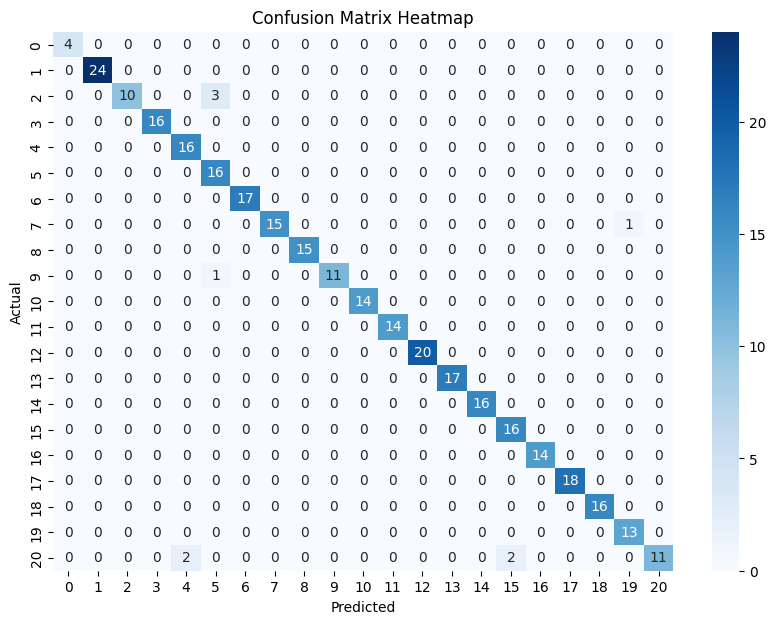

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()
